In [1]:
import chaospy
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.io as pio
from chaospy.descriptives.expected import E
from sklearn import linear_model as lm

pio.renderers.default = "notebook_connected"

In [2]:
df = pd.read_hdf("./LPRES3000_tRp400_21-12-28.h5")

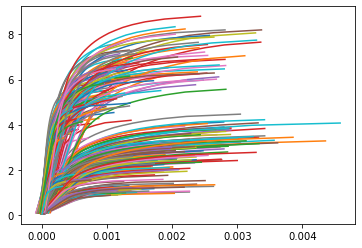

In [3]:
for R in df["R"].unique():
    df_curve = df[df["R"] == R]
    plt.plot(df_curve.u, df_curve.load)

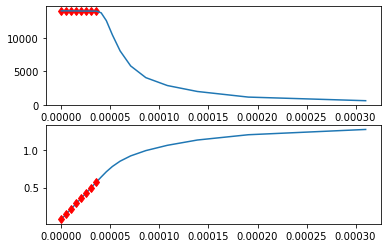

In [4]:
grd = np.gradient(df_curve.load, df_curve.u)

for i in range(grd.size):
    if grd[i] / grd[i + 1] > 1.05:
        break
    # print(i,grd[i])
plt.subplot(2, 1, 1)
plt.plot(df_curve.u[:i], grd[:i], "rd")
plt.plot(df_curve.u, grd)
plt.subplot(2, 1, 2)
plt.plot(df_curve.u, df_curve.load)
plt.plot(df_curve.u[:i], df_curve.load[:i], "rd")

In [5]:
idx = []
thres = 1.01
for R in df["R"].unique():
    df_curve = df[df["R"] == R]
    grd = np.gradient(df_curve.load, df_curve.u)

    for i in range(grd.size):
        if grd[i] / grd[i + 1] > thres:
            break
    id = df.index[df.u == df_curve.u.values[i]].values[0]
    # print(id)
    idx.append(id)
print(f"{len(idx)=}")

len(idx)=400


In [6]:
px.scatter_3d(df.iloc[idx], x="R", y="t", z="load")

In [7]:
case_incr_max = [
    df["incr"][df["R"] == unique_R].idxmax() for unique_R in df["R"].unique()
]

px.scatter_3d(df.iloc[case_incr_max], x="R", y="t", z="load")

In [8]:
idx = []
thres = 1.01
for R in df["R"].unique():
    df_curve = df[df["R"] == R]

    t = df_curve.t.unique()[0]
    p = df_curve.p.unique()[0]
    x = np.linspace(df_curve.u.min(), df_curve.u.max(), 1000)
    f = np.interp(x, df_curve.u, df_curve.load)
    grd = np.gradient(f, x)

    for i in range(grd.size):
        if grd[i] / grd[i + 1] > thres:
            break

    idx.append([f[i], t, R, p])

print(len(idx))
df_wrinkle = pd.DataFrame(np.asarray(idx), columns=["load", "t", "R", "p"])

px.scatter_3d(df_wrinkle, x="t", y="R", z="load")

400


In [9]:
t = [25e-6, 75e-6]
R = [0.02, 0.04]
p = [8e3, 1.2e4]

dist_t = chaospy.Uniform(*t)
dist_r = chaospy.Uniform(*R)
dist_p = chaospy.Uniform(*p)

joint = chaospy.J(dist_t, dist_r, dist_p)
# joint = chaospy.J(dist_r, dist_p)
expansion = chaospy.generate_expansion(3, joint)

In [10]:
doe = df.iloc[case_incr_max]

samples = doe[["t", "R", "p"]].values
# samples = doe[["R", "p"]].values
evaluations = doe["load"]

pce_model = chaospy.fit_regression(expansion, samples.T, evaluations)

<ipython-input-11-bab2c25518cc>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



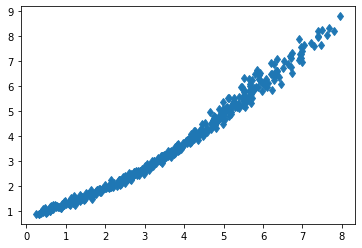

In [11]:
doe["pce"] = pce_model(*samples.T)
plt.plot(doe.pce, doe.load, "d")

In [12]:
px.scatter_3d(doe, x="p", y="R", z="pce")

In [13]:
px.scatter_3d(doe, x="p", y="R", z="load")

In [14]:
model = lm.Lars(fit_intercept=False)
lars_pce = chaospy.fit_regression(expansion, samples.T, evaluations, model=model)

<ipython-input-15-f29cd28c0891>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



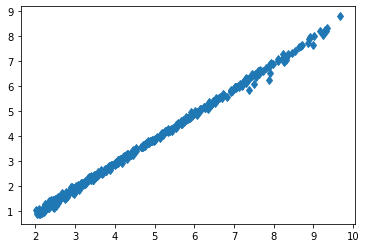

In [15]:
doe["lars"] = lars_pce(*samples.T)
plt.plot(doe.lars, doe.load, "d")

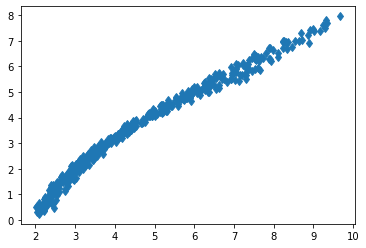

In [16]:
plt.plot(doe.lars, doe.pce, "d")

In [17]:
px.scatter_3d(doe, x="t", y="R", z="lars")

In [18]:
px.scatter_3d(doe, x="t", y="R", z="pce")

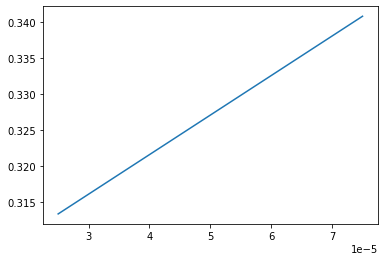

In [19]:
t_test = np.linspace(*t, 20)
r_test = 0.02 * np.ones(t_test.shape)
p_test = 1e4 * np.ones(t_test.shape)

test = np.vstack([t_test, r_test, p_test])
plt.plot(t_test, pce_model(*test))

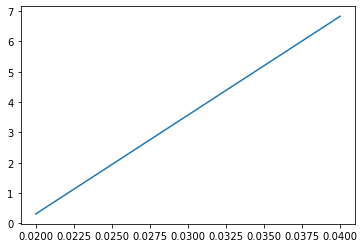

In [20]:
r_test = np.linspace(*R, 20)
t_test = 20e-6 * np.ones(r_test.shape)
p_test = 1e4 * np.ones(t_test.shape)

test = np.vstack([t_test, r_test, p_test])
plt.plot(r_test, pce_model(*test))

In [21]:
t_mean = 37.5e-6
R_mean = 0.03
L = 0.6

V = 2 * np.pi * R_mean * t_mean * L
print(f"{V=}")


def t_constraint(r):
    return V / (r * (2 * np.pi * L))

V=4.24115008234622e-06


In [22]:
r = np.linspace(0.02, 0.04, 100)
t = t_constraint(r)
p = np.ones(r.shape) * 1e4

In [23]:
test = np.vstack([t, r, p])
pred = pce_model(*test)

In [24]:
opt = pd.DataFrame(np.vstack([t, r, pred]).T, columns=["t", "R", "pce"])

In [25]:
px.scatter_3d(opt, x="t", y="R", z="pce")

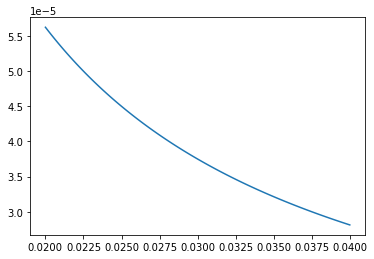

In [26]:
plt.plot(r, t)

In [27]:
opt.iloc[opt["pce"].idxmin()]

t      0.000056
R      0.020000
pce    0.330533
Name: 0, dtype: float64

In [28]:
opt.iloc[opt["pce"].idxmax()]

t      0.000028
R      0.040000
pce    6.832029
Name: 99, dtype: float64

In [29]:
px.scatter(df, x="u", y="load", color="R")

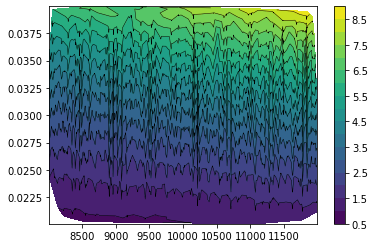

In [30]:
x = doe.p
y = doe.R
z = doe.load
plt.tricontour(x, y, z, 15, linewidths=0.5, colors="k")
plt.tricontourf(x, y, z, 15)
plt.colorbar()